In [48]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [49]:
writer = SummaryWriter(f'runs/mnist/сvae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 10
latent_dim = 2
hidden_dim = 128

In [50]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [51]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [52]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [53]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [54]:
@dataclass
class СVAEToken:
    """
    Выходные данные для CVAE.
    
    Поля:
        z_logvar (torch.distributions.Distribution): Распределение скрытой переменной z.
        z_sample (torch.Tensor): Семплированное значение z от VAE.
        x_hat (torch.Tensor): Декодированное значение для VAE.
        loss (torch.Tensor): Общий лосс для CVAE.
        loss_recon (torch.Tensor): Ошибка реконструкции для VAE.
        loss_kl (torch.Tensor): Компонент KL дивергенции VAE.
        loss_fuzzy (torch.Tensor): Лосс нечеткого слоя.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_hat: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor
    #loss_fuzzy: torch.Tensor

In [55]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) 
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(), 
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(), 
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(), 
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(), 
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Кодирует входной вектор в латентный.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшое значение для лучшей сходимости.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Репараметризация.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Декодирует латентный вектор в представление в исходном пространстве.        
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Полный проход по VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            compute_loss (bool): Нужно ли считать лосс.
        
        Returns:
            СVAEToken
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return СVAEToken(
                z_dist = dist,
                z_sample=z,
                x_hat=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return СVAEToken(
            z_dist = dist,
            z_sample=z,
            x_hat=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [56]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 223,572


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): SiLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): SiLU()
    (8): Linear(in_features=16, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): SiLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): SiLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): SiLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [57]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [58]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [59]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_hat.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [60]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 544.3109 (Recon: 544.0287, KL: 0.2822) Grad: 12.8843
Step 100 (N samples: 12,800), Loss: 200.0813 (Recon: 196.0695, KL: 4.0118) Grad: 141.5294
Step 200 (N samples: 25,600), Loss: 201.3673 (Recon: 198.7451, KL: 2.6222) Grad: 201.2017
Step 300 (N samples: 38,400), Loss: 200.5323 (Recon: 198.3050, KL: 2.2273) Grad: 42.3667
Step 400 (N samples: 51,200), Loss: 193.3269 (Recon: 191.3018, KL: 2.0252) Grad: 66.8916


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 190.5583 (BCE: 188.6222, KLD: 1.9361)
Epoch 2/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500 (N samples: 64,000), Loss: 196.1690 (Recon: 194.2400, KL: 1.9290) Grad: 138.0752
Step 600 (N samples: 76,800), Loss: 195.2741 (Recon: 193.2431, KL: 2.0310) Grad: 35.3571
Step 700 (N samples: 89,600), Loss: 192.3091 (Recon: 190.2092, KL: 2.0999) Grad: 70.6127
Step 800 (N samples: 102,400), Loss: 186.8276 (Recon: 184.7005, KL: 2.1271) Grad: 74.4002
Step 900 (N samples: 115,200), Loss: 187.1176 (Recon: 185.0166, KL: 2.1010) Grad: 32.7349


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 185.2778 (BCE: 183.0448, KLD: 2.2330)
Epoch 3/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,000 (N samples: 128,000), Loss: 185.1400 (Recon: 182.8766, KL: 2.2634) Grad: 11.5402
Step 1,100 (N samples: 140,800), Loss: 183.6951 (Recon: 181.4278, KL: 2.2673) Grad: 11.6177
Step 1,200 (N samples: 153,600), Loss: 187.5557 (Recon: 185.0902, KL: 2.4655) Grad: 25.0055
Step 1,300 (N samples: 166,400), Loss: 171.9072 (Recon: 169.2049, KL: 2.7023) Grad: 44.0282
Step 1,400 (N samples: 179,200), Loss: 177.8598 (Recon: 175.2386, KL: 2.6212) Grad: 51.8316


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 179.0147 (BCE: 176.2200, KLD: 2.7948)
Epoch 4/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,500 (N samples: 192,000), Loss: 179.6097 (Recon: 176.8900, KL: 2.7197) Grad: 169.7007
Step 1,600 (N samples: 204,800), Loss: 182.0946 (Recon: 179.1031, KL: 2.9915) Grad: 17.7483
Step 1,700 (N samples: 217,600), Loss: 178.4999 (Recon: 175.6526, KL: 2.8473) Grad: 122.9368
Step 1,800 (N samples: 230,400), Loss: 173.9041 (Recon: 170.8283, KL: 3.0759) Grad: 56.7454


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.1468 (BCE: 172.0048, KLD: 3.1420)
Epoch 5/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,900 (N samples: 243,200), Loss: 175.6917 (Recon: 172.5452, KL: 3.1465) Grad: 137.7954
Step 2,000 (N samples: 256,000), Loss: 174.9388 (Recon: 172.0016, KL: 2.9372) Grad: 42.0612
Step 2,100 (N samples: 268,800), Loss: 172.6170 (Recon: 169.5605, KL: 3.0565) Grad: 38.8487
Step 2,200 (N samples: 281,600), Loss: 176.7272 (Recon: 173.7664, KL: 2.9608) Grad: 251.3046
Step 2,300 (N samples: 294,400), Loss: 171.0648 (Recon: 168.0269, KL: 3.0379) Grad: 269.6043


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.9499 (BCE: 169.8840, KLD: 3.0659)
Epoch 6/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,400 (N samples: 307,200), Loss: 174.5322 (Recon: 171.4641, KL: 3.0681) Grad: 238.2896
Step 2,500 (N samples: 320,000), Loss: 163.6803 (Recon: 160.5503, KL: 3.1300) Grad: 138.8701
Step 2,600 (N samples: 332,800), Loss: 169.6046 (Recon: 166.5574, KL: 3.0471) Grad: 124.8264
Step 2,700 (N samples: 345,600), Loss: 173.7634 (Recon: 170.5263, KL: 3.2371) Grad: 84.1646
Step 2,800 (N samples: 358,400), Loss: 175.9062 (Recon: 172.5921, KL: 3.3142) Grad: 44.6501


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.7575 (BCE: 167.5485, KLD: 3.2089)
Epoch 7/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,900 (N samples: 371,200), Loss: 177.3910 (Recon: 174.2127, KL: 3.1783) Grad: 57.1207
Step 3,000 (N samples: 384,000), Loss: 172.5788 (Recon: 169.3760, KL: 3.2028) Grad: 37.8359
Step 3,100 (N samples: 396,800), Loss: 175.6256 (Recon: 172.5557, KL: 3.0699) Grad: 76.0137
Step 3,200 (N samples: 409,600), Loss: 168.0073 (Recon: 164.5858, KL: 3.4216) Grad: 60.4707


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.7377 (BCE: 166.4870, KLD: 3.2506)
Epoch 8/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,300 (N samples: 422,400), Loss: 168.4531 (Recon: 165.1510, KL: 3.3021) Grad: 135.1389
Step 3,400 (N samples: 435,200), Loss: 165.6515 (Recon: 162.4379, KL: 3.2136) Grad: 186.3105
Step 3,500 (N samples: 448,000), Loss: 171.1022 (Recon: 167.4608, KL: 3.6414) Grad: 70.0713
Step 3,600 (N samples: 460,800), Loss: 172.5805 (Recon: 169.1329, KL: 3.4476) Grad: 101.4288
Step 3,700 (N samples: 473,600), Loss: 159.3605 (Recon: 155.8974, KL: 3.4631) Grad: 82.7272


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.5704 (BCE: 165.1505, KLD: 3.4199)
Epoch 9/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,800 (N samples: 486,400), Loss: 172.8236 (Recon: 169.3351, KL: 3.4885) Grad: 72.3708
Step 3,900 (N samples: 499,200), Loss: 169.2223 (Recon: 165.7720, KL: 3.4503) Grad: 123.4694
Step 4,000 (N samples: 512,000), Loss: 163.7349 (Recon: 160.3843, KL: 3.3506) Grad: 82.6054
Step 4,100 (N samples: 524,800), Loss: 170.4236 (Recon: 166.9739, KL: 3.4497) Grad: 134.6378
Step 4,200 (N samples: 537,600), Loss: 164.9645 (Recon: 161.4648, KL: 3.4996) Grad: 57.6827


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.1394 (BCE: 164.6506, KLD: 3.4888)
Epoch 10/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,300 (N samples: 550,400), Loss: 169.9609 (Recon: 166.4446, KL: 3.5163) Grad: 145.5294
Step 4,400 (N samples: 563,200), Loss: 165.7837 (Recon: 162.3532, KL: 3.4305) Grad: 164.9131
Step 4,500 (N samples: 576,000), Loss: 168.4717 (Recon: 165.0972, KL: 3.3745) Grad: 106.8380
Step 4,600 (N samples: 588,800), Loss: 172.6596 (Recon: 169.2807, KL: 3.3789) Grad: 81.0067


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.5587 (BCE: 163.1179, KLD: 3.4408)


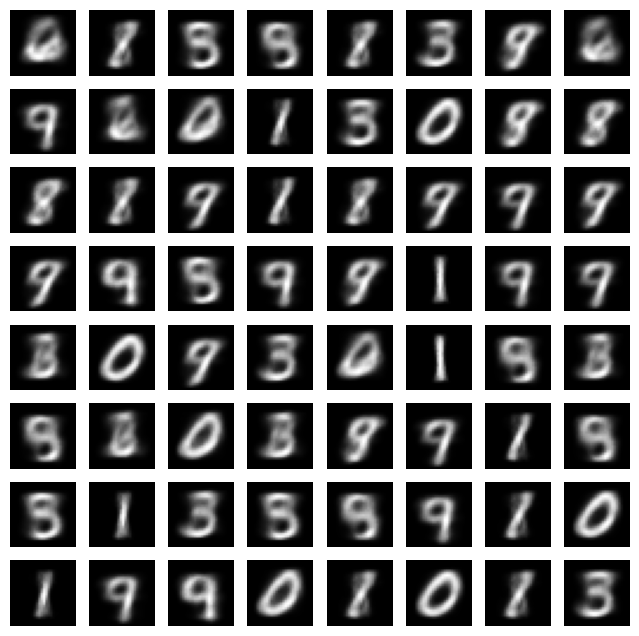

In [61]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [62]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

Encoding:   0%|          | 0/469 [00:00<?, ?it/s]

In [63]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

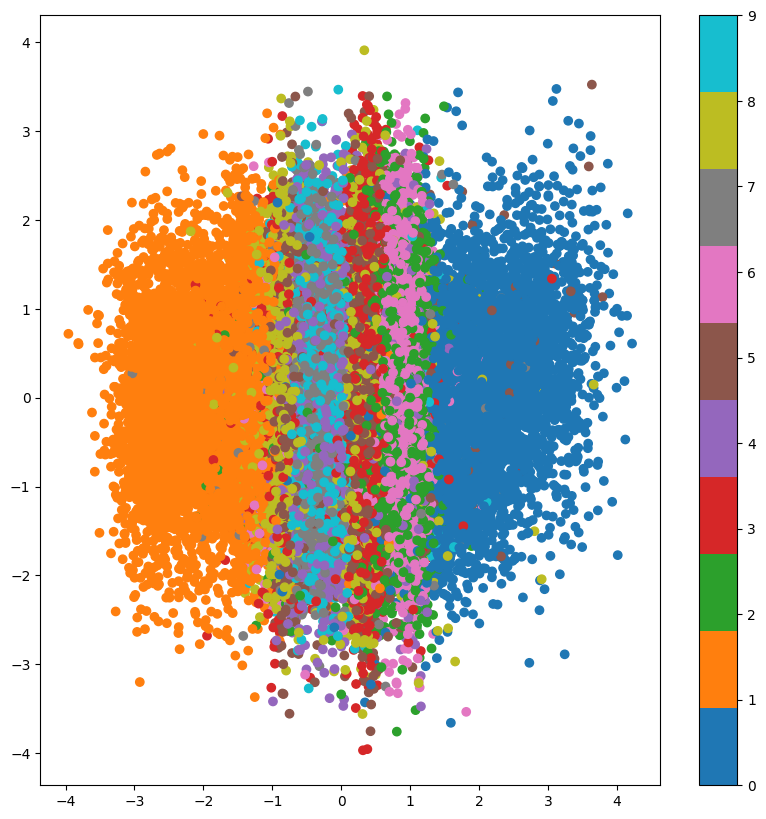

In [64]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

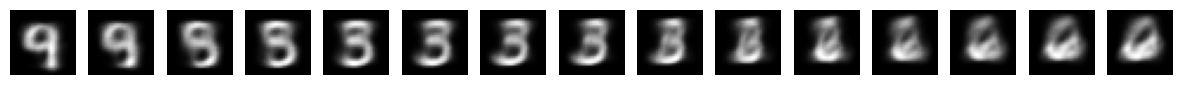

In [65]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')